In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch.nn.functional as F
import pandas as pd
import copy

from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset, ConcatDataset
from rdkit import Chem
from conf_ensemble_dataset_in_memory import ConfEnsembleDataset
from rdkit.Chem import AllChem #needed for rdForceFieldHelpers
from collections import defaultdict
from litschnet import LitSchNet
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from rmsd_predictor_evaluator import RMSDPredictorEvaluator
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:
pl.seed_everything(42, workers=True)

Global seed set to 42


42

# Data preparation

In [3]:
data_dir = 'data/'

In [4]:
# run once to preprocess datasets and generate chunks
# dataset = ConfEnsembleDataset()
# dataset = ConfEnsembleDataset(dataset='platinum') # 16G

In [5]:
platinum_chunks = [filename for filename in os.listdir(os.path.join(data_dir, 'processed')) if filename.startswith('platinum')]
platinum_n_chunks = len(platinum_chunks)

In [6]:
platinum_datasets = []
for chunk_number in tqdm(range(platinum_n_chunks)) :
    dataset = ConfEnsembleDataset(dataset='platinum', loaded_chunk=chunk_number)
    platinum_datasets.append(dataset)
platinum_dataset = ConcatDataset(platinum_datasets)

100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.02s/it]


In [7]:
pdbbind_chunks = [filename for filename in os.listdir(os.path.join(data_dir, 'processed')) if filename.startswith('pdbbind')]
pdbbind_n_chunks = len(pdbbind_chunks)

100%|█████████████████████████████████████████████| 3/3 [03:29<00:00, 69.91s/it]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:57: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/home/benoit/bioactive_conformation_predictor/litschnet.py:44: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred.squeeze(), target)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.43661245703697205}
--------------------------------------------------------------------------------
Grouping data by smiles
Starting evaluation
Mean loss : 0.42


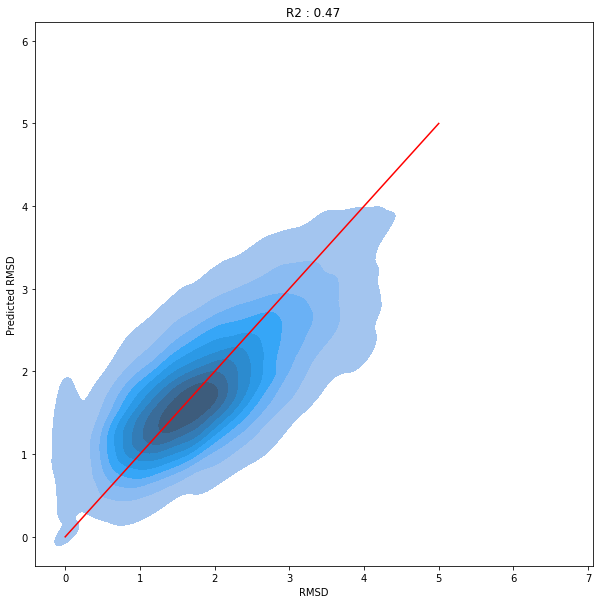

Bioactive ranking accuracy : 0.27675869308222245
Median rank : 6.0


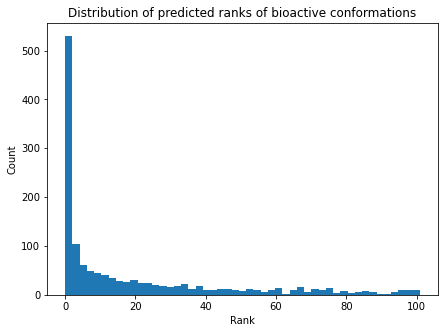

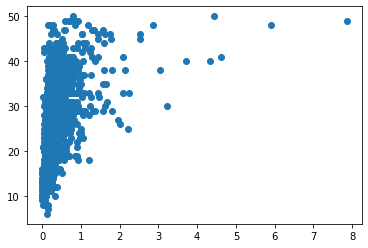

Generated ranking accuracy : 0.10747663551401869
CCDC ranking accuracy : 0.09439252336448598
EF20% prediction : 1.807606974842266
EF20% CCDC : 1.3163667458502997
Grouping data by smiles
Starting evaluation
Mean loss : 0.30


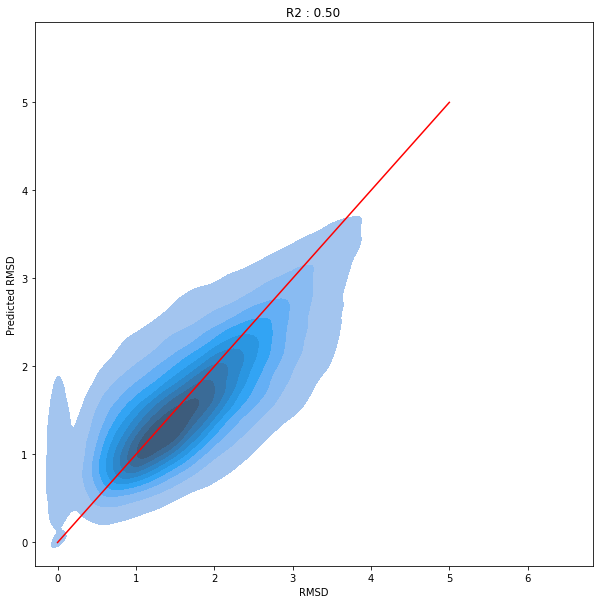

Bioactive ranking accuracy : 0.27901272906220137
Median rank : 5.0


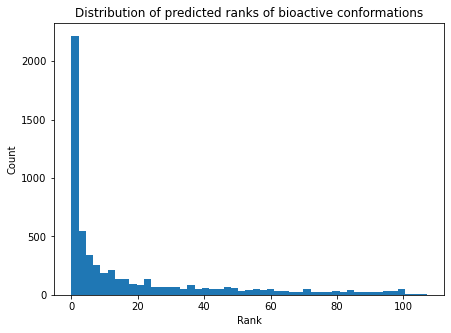

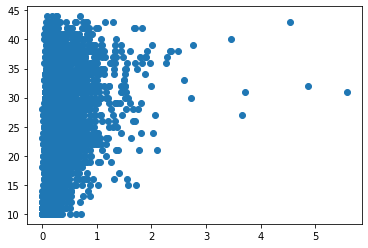

  0%|                                                     | 0/3 [00:00<?, ?it/s]

Generated ranking accuracy : 0.14844952716076534
CCDC ranking accuracy : 0.1341543875082472
EF20% prediction : 2.0785209600579253
EF20% CCDC : 1.4405233565663045


100%|█████████████████████████████████████████████| 3/3 [03:32<00:00, 70.75s/it]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4596305191516876}
--------------------------------------------------------------------------------
Grouping data by smiles
Starting evaluation
Mean loss : 0.41


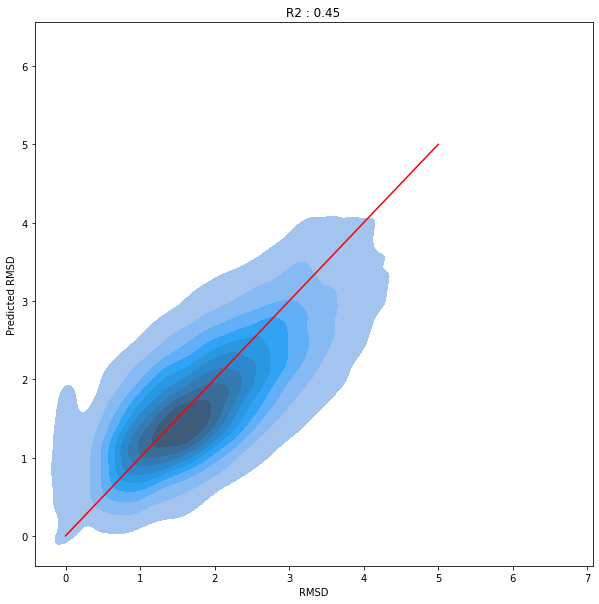

Bioactive ranking accuracy : 0.2680040190566506
Median rank : 6.0


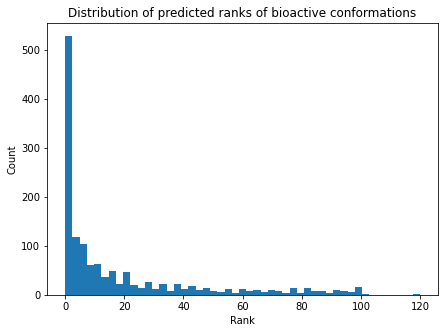

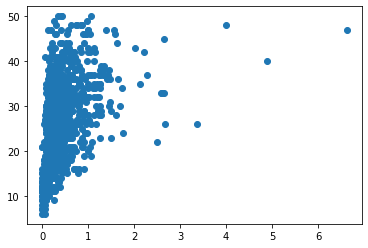

Generated ranking accuracy : 0.09107806691449814
CCDC ranking accuracy : 0.09851301115241635
EF20% prediction : 1.8116432865492922
EF20% CCDC : 1.2966295240236143
Grouping data by smiles
Starting evaluation
Mean loss : 0.34


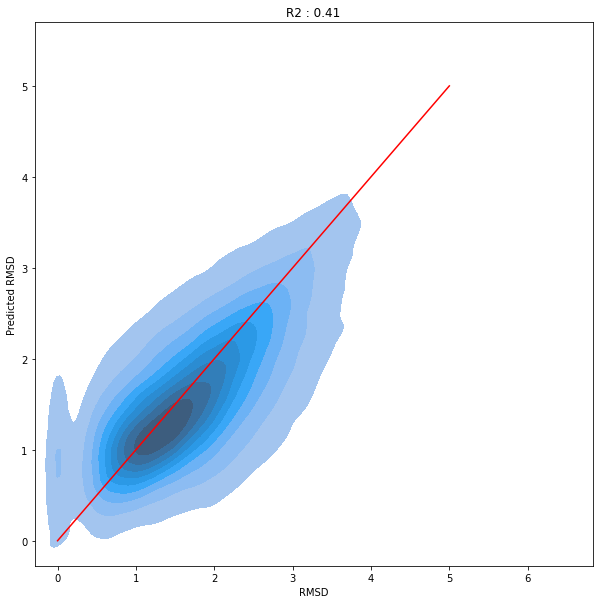

Bioactive ranking accuracy : 0.27716297127576806
Median rank : 5.0


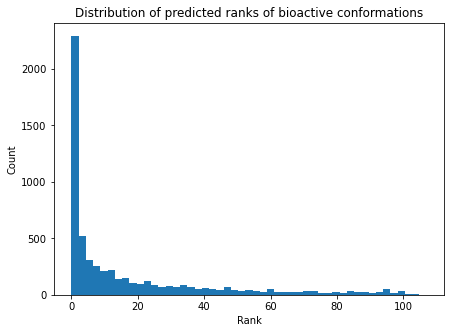

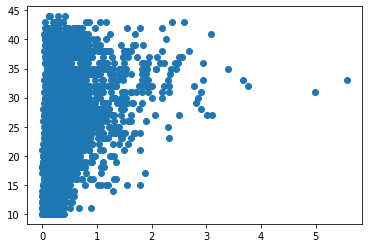

Generated ranking accuracy : 0.14141191994721794
CCDC ranking accuracy : 0.1341543875082472
EF20% prediction : 2.031473144229635
EF20% CCDC : 1.4405233565663045


In [8]:
for iteration in range(2) :
    with open(os.path.join(data_dir, 'scaffold_splits', f'train_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
        train_smiles = f.readlines()
        train_smiles = [smiles.strip() for smiles in train_smiles]
    
    with open(os.path.join(data_dir, 'scaffold_splits', f'val_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
        val_smiles = f.readlines()
        val_smiles = [smiles.strip() for smiles in val_smiles]

    with open(os.path.join(data_dir, 'scaffold_splits', f'test_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
        test_smiles = f.readlines()
        test_smiles = [smiles.strip() for smiles in test_smiles]
        
    train_datasets = []
    val_datasets = []
    test_datasets = []

    for chunk_number in tqdm(range(pdbbind_n_chunks)) :

        dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                      smiles_list=train_smiles)
        train_datasets.append(dataset)

        dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                      smiles_list=val_smiles)
        val_datasets.append(dataset)

        dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                      smiles_list=test_smiles)
        test_datasets.append(dataset)
        
    train_dataset = ConcatDataset(train_datasets)
    val_dataset = ConcatDataset(val_datasets)
    test_dataset = ConcatDataset(test_datasets)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
    
    experiment_name = f'scaffold_split_{iteration}_new'
    if experiment_name in os.listdir('lightning_logs') :
        checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
        checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
        litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
    else :
        litschnet = LitSchNet()
        logger = TensorBoardLogger(save_dir=os.getcwd(), version=experiment_name, name="lightning_logs")
        trainer = pl.Trainer(logger=logger, callbacks=[EarlyStopping(monitor="val_loss", patience=5)], gpus=1)
        trainer.fit(litschnet, train_loader, val_loader)
        trainer.test(litschnet, test_loader)
    
    evaluator = RMSDPredictorEvaluator(model=litschnet)
    evaluator.evaluate(test_dataset)
    evaluator.evaluation_report()

    evaluator = RMSDPredictorEvaluator(model=litschnet)
    evaluator.evaluate(platinum_dataset)
    evaluator.evaluation_report()

100%|█████████████████████████████████████████████| 3/3 [03:33<00:00, 71.07s/it]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

/home/benoit/bioactive_conformation_predictor/litschnet.py:30: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred.squeeze(), target)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4236045777797699}
--------------------------------------------------------------------------------
Grouping data by smiles


Traceback (most recent call last):
  File "/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/benoit/anaconda3/envs/GeoM

Starting evaluation
Mean loss : 0.39


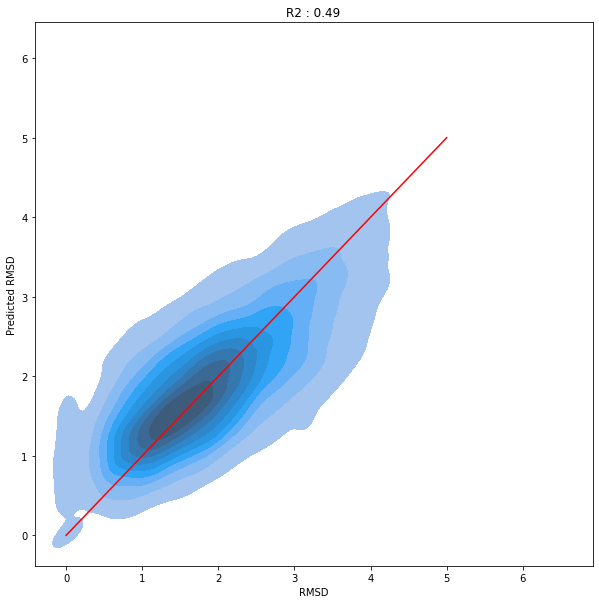

Bioactive ranking accuracy : 0.3346051979280113
Median rank : 3.0


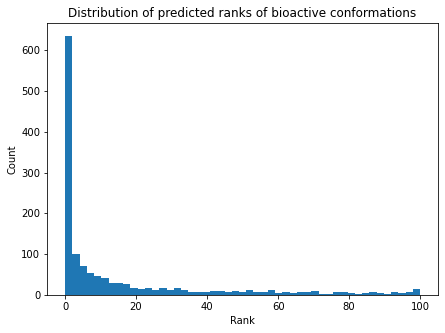

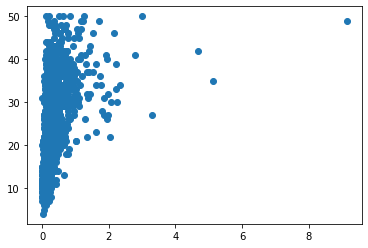

Generated ranking accuracy : 0.12628624883068287
CCDC ranking accuracy : 0.1019644527595884
EF20% prediction : 2.0760681671872243
EF20% CCDC : 1.2993930208175406
Grouping data by smiles
Starting evaluation
Mean loss : 0.30


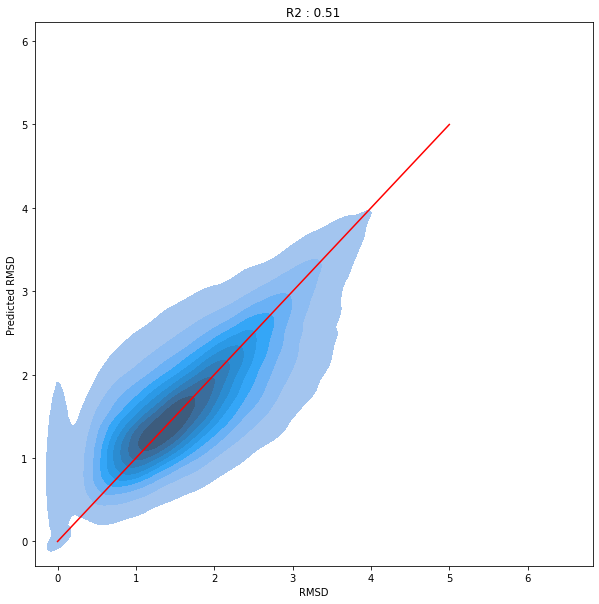

Bioactive ranking accuracy : 0.3359475836388765
Median rank : 4.0


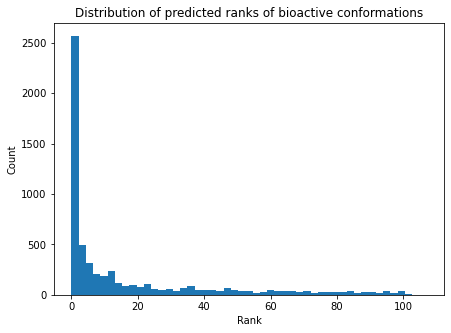

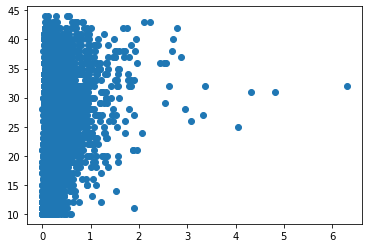


  0%|                                                     | 0/3 [00:00<?, ?it/s]

Generated ranking accuracy : 0.1667033208709039
CCDC ranking accuracy : 0.1341543875082472
EF20% prediction : 2.2048366848186207
EF20% CCDC : 1.4405233565663045



 67%|██████████████████████████████               | 2/3 [02:31<01:15, 75.87s/it]

In [ ]:
for iteration in range(2) :
    with open(os.path.join(data_dir, 'random_splits', f'train_smiles_random_split_{iteration}.txt'), 'r') as f :
        train_smiles = f.readlines()
        train_smiles = [smiles.strip() for smiles in train_smiles]
    
    with open(os.path.join(data_dir, 'random_splits', f'val_smiles_random_split_{iteration}.txt'), 'r') as f :
        valid_smiles = f.readlines()
        valid_smiles = [smiles.strip() for smiles in valid_smiles]

    with open(os.path.join(data_dir, 'random_splits', f'test_smiles_random_split_{iteration}.txt'), 'r') as f :
        test_smiles = f.readlines()
        test_smiles = [smiles.strip() for smiles in test_smiles]
        
    train_datasets = []
    val_datasets = []
    test_datasets = []

    for chunk_number in tqdm(range(pdbbind_n_chunks)) :

        dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                      smiles_list=train_smiles)
        train_datasets.append(dataset)

        dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                      smiles_list=val_smiles)
        val_datasets.append(dataset)

        dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                      smiles_list=test_smiles)
        test_datasets.append(dataset)
        
    train_dataset = ConcatDataset(train_datasets)
    val_dataset = ConcatDataset(val_datasets)
    test_dataset = ConcatDataset(test_datasets)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
    
    experiment_name = f'random_split_{iteration}_new'
    if experiment_name in os.listdir('lightning_logs') :
        checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
        checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
        litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
    else :
        litschnet = LitSchNet()
        logger = TensorBoardLogger(save_dir=os.getcwd(), version=experiment_name, name="lightning_logs")
        trainer = pl.Trainer(logger=logger, callbacks=[EarlyStopping(monitor="val_loss", patience=5)], gpus=1)
        trainer.fit(litschnet, train_loader, val_loader)
        trainer.test(litschnet, test_loader)
    
    evaluator = RMSDPredictorEvaluator(model=litschnet)
    evaluator.evaluate(test_dataset)
    evaluator.evaluation_report()

    evaluator = RMSDPredictorEvaluator(model=litschnet)
    evaluator.evaluate(platinum_dataset)
    evaluator.evaluation_report()